# ECE 232E Project 3: Reinforcement learning and Inverse Reinforcement learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from cvxopt import solvers, matrix

%matplotlib inline

# 2. Reinforcement learning (RL)

### 2.1.4 Reward function

<div class="alert alert-block alert-success">
<b>Question 1:</b> (10 points) For visualization purpose, generate heat maps of Reward function 1 and Reward function 2. For the heat maps, make sure you display the coloring scale. You will have 2 plots for this question.
</div>

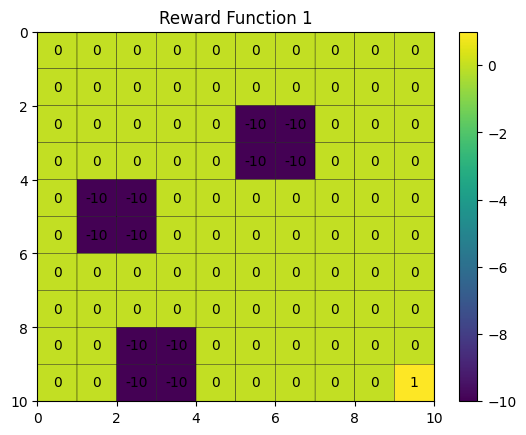

In [2]:
# Reward function 1
rwd_f1 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                   [0, 0, 0, 0, 0, -10, -10, 0, 0, 0], 
                   [0, 0, 0, 0, 0, -10, -10, 0, 0, 0], 
                   [0, -10, -10, 0, 0, 0, 0, 0, 0, 0], 
                   [0, -10, -10, 0, 0, 0, 0, 0, 0, 0], 
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                   [0, 0, -10, -10, 0, 0, 0, 0, 0, 0], 
                   [0, 0, -10, -10, 0, 0, 0, 0, 0, 1]])

plt.pcolor(rwd_f1, edgecolors='black')
plt.title("Reward Function 1")
for (j,i),label in np.ndenumerate(rwd_f1):
  plt.text(i+0.5, j+0.5, label, ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

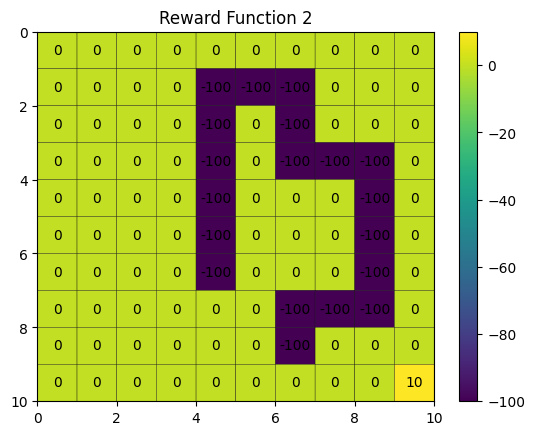

In [3]:
# Reward function 2
rwd_f2 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                   [0, 0, 0, 0, -100, -100, -100, 0, 0, 0], 
                   [0, 0, 0, 0, -100, 0, -100, 0, 0, 0], 
                   [0, 0, 0, 0, -100, 0, -100, -100, -100, 0], 
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0], 
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0], 
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0], 
                   [0, 0, 0, 0, 0, 0, -100, -100, -100, 0], 
                   [0, 0, 0, 0, 0, 0, -100, 0, 0, 0], 
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 10]])

plt.pcolor(rwd_f2, edgecolors='black')
plt.title("Reward Function 2")
for (j,i),label in np.ndenumerate(rwd_f2):
  plt.text(i+0.5, j+0.5, label, ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 1:</b> The results are shown above.
</div>

In [ ]:
# rwd_f1.T.reshape(-1)
# rwd_f1.reshape(-1, order="F")
# rwd_f1.flatten("F")
# (rwd_f1.T).ravel()

# 3. Optimal policy learning using RL algorithms

<div class="alert alert-block alert-success">
<b>Question 2:</b> (40 points) Create the environment of the agent using the information provided in section 2. To be specific, create the MDP by setting up the state-space, action set, transition probabilities, discount factor, and reward function. 

After you have created the environment, then write an optimal state-value function that takes as input the environment of the agent and outputs the optimal value of each state in the grid. For the optimal state-value function, you have to implement the Initialization (lines 2-4) and Estimation (lines 5-13) steps of the Value Iteration algorithm. For the estimation step, use $\epsilon = 0.01$. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state. In this part of question, you should have 1 plot.

Let's assume that your value iteration algorithm converges in N steps. Plot snapshots of state values in 5 different steps linearly distributed from 1 to N. Report N and your step numbers. What observations do you have from the plots?

</div>

In [4]:
"""
Create the environment:
  state-space, action set, reward function, 
  discount factor, and transition probabilities
"""

# get all neighbors of a state, if doesn't exist, then will be itself
def get_nbr(state, state_space):
  row, col = state_space[state]
  # get the neighbor coordinate
  r_nbr = (row, col+1) if col+1 <= 9 else (row, col)
  l_nbr = (row, col-1) if col-1 >= 0 else (row, col)
  u_nbr = (row-1, col) if row-1 >= 0 else (row, col)
  d_nbr = (row+1, col) if row+1 <= 9 else (row, col)

  # return neighbor state - order ["right", "left", "up", "down"]
  return (r_nbr[0]+r_nbr[1]*10, l_nbr[0]+l_nbr[1]*10, 
          u_nbr[0]+u_nbr[1]*10, d_nbr[0]+d_nbr[1]*10)
  

# get the transition probabilities matrix for each action
def get_tp(w, actions, state_space):
  # init
  tp = dict()
  for act in actions:
    tp[act] = np.zeros((100, 100))

  # iterate through each state
  for i in range(num_states):
    nbrs = get_nbr(i, state_space)
    for a in range(len(actions)):
      for n in range(len(nbrs)):
        tp[actions[a]][i, nbrs[n]] += w/4
        if a == n:
          tp[actions[a]][i, nbrs[n]] += 1 - w
  
  return tp

In [5]:
# create a state_space for mapping of states numbering and coordinate
num_states = 100
state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)

# action set
num_acts = 4
act_sets = np.array(["right", "left", "up", "down"])

# reward function (#1) in 1D
rwd = rwd_f1.flatten("F")

# discount factor
gamma = 0.8

# transition probabilities matrix with probability w 
w = 0.1
tp = get_tp(w, act_sets, state_space)

In [6]:
"""
Implement the Initialization (lines 2-4) and 
Estimation (lines 5-13) steps of the Value Iteration algorithm
"""

# create an optimal state-value function
def optimal_state_value_function(tp, rwd, state_space, actions, gamma, epsilon):
  # init
  Vs = np.zeros(len(state_space))
  delta = np.inf
  num_steps = 0
  old_Vs = np.copy(Vs)

  while delta > epsilon:
    delta = 0
    for i in range(len(state_space)):
      Vs[i] = max([np.sum(tp[act][i]*(rwd + gamma*old_Vs)) for act in actions])
      delta = max(delta, abs(old_Vs[i] - Vs[i]))
    old_Vs = np.copy(Vs)
    num_steps += 1
  
  return Vs, num_steps

Number of steps needed to converge: 22



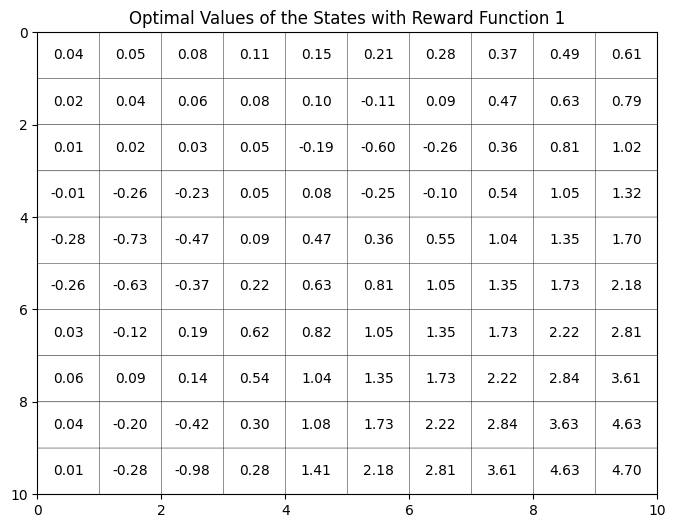

In [ ]:
epsilon = 0.01
V_opt, num_steps = optimal_state_value_function(tp, rwd, state_space, act_sets, gamma, epsilon)

# report
print("Number of steps needed to converge: {}\n".format(num_steps))
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_opt.reshape((10, 10)).T, edgecolors='black', cmap=ListedColormap(['white']))
plt.title("Optimal Values of the States with Reward Function 1")
for (j, i), label in np.ndenumerate(V_opt.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
# plt.colorbar()
plt.show()

In [ ]:
"""
Plot snapshots of state values in 5 different steps linearly 
distributed from 1 to N. Report N and your step numbers. 
What observations do you have from the plots?

Based on the result above, N = 22 and thus I choose step size = 5
"""

# create an optimal state-value function
def snapshots_state_value(tp, rwd, state_space, actions, gamma, epsilon, step_size):
  # init
  Vs = np.zeros(len(state_space))
  delta = np.inf
  num_steps = 0
  old_Vs = np.copy(Vs)
  snapshots = []

  while delta > epsilon:
    delta = 0
    if num_steps%step_size == 1 and num_steps != 0:
      snapshots.append(np.copy(Vs))

    for i in range(len(state_space)):
      Vs[i] = max([np.sum(tp[act][i]*(rwd + gamma*old_Vs)) for act in actions])
      delta = max(delta, abs(old_Vs[i] - Vs[i]))
    old_Vs = np.copy(Vs)
    num_steps += 1
  
  return Vs, num_steps, snapshots

Number of steps needed to converge: 22



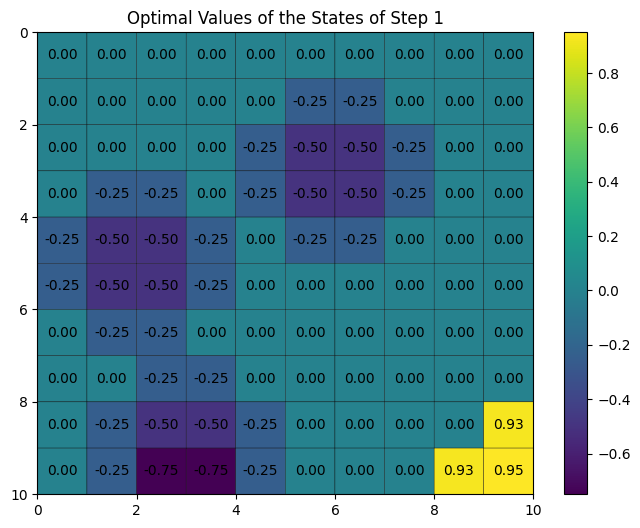

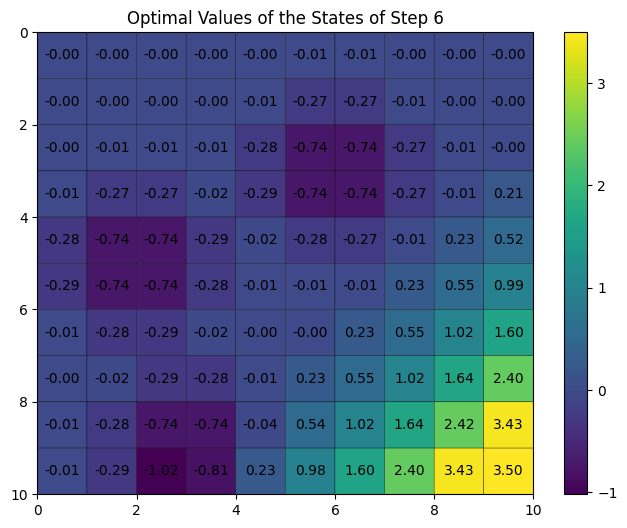

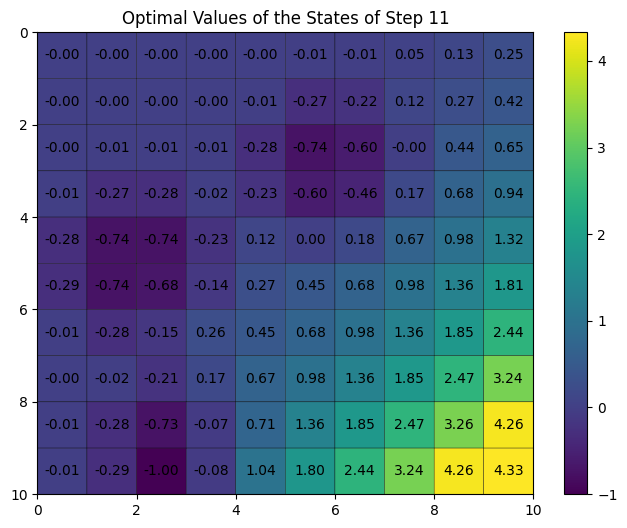

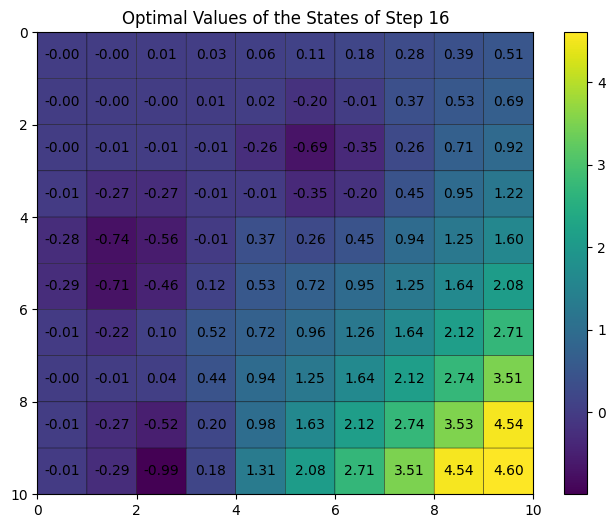

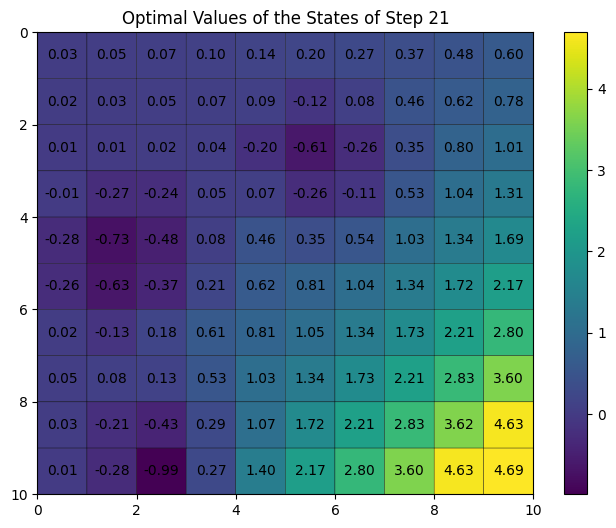

In [ ]:
step_size = 5
V_opt, num_steps, snapshots = snapshots_state_value(tp, rwd, state_space, act_sets, gamma, epsilon, step_size)

# report
print("Number of steps needed to converge: {}\n".format(num_steps))
# plots
N = 1
for i in range(len(snapshots)):
  V_opt_snap = snapshots[i]
  plt.figure(figsize=(8, 6))
  plt.pcolor(V_opt_snap.reshape((10, 10)).T, edgecolors='black')
  plt.title("Optimal Values of the States of Step {}".format(N))
  for (j, i), label in np.ndenumerate(V_opt_snap.reshape((10, 10)).T):
    plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
  N += step_size
  plt.gca().invert_yaxis()
  plt.colorbar()
  plt.show()

<div class="alert alert-block alert-success">
<b>Answer 2:</b> The plots with generated optimum state values are shown above. In total, the value iteration algorithm converges in 22 steps and I plot step [1, 6, 11, 16, 21] for the second part. Based on the plots, we can observe that the more steps we take, the further states away from the positive and negative rewards can be influenced, which leads to a low to high distribution, generally from top-left corner to bottom-right corner. Moreover, the state 99 with the only positive reward has the highest optimal value and the other states with the negative reward have the lowest optimal value compared with their surrounding states with 0 reward.
</div>

<div class="alert alert-block alert-success">
<b>Question 3:</b> (5 points) Generate a heat map of the optimal state values across the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier (see the hint after question 1).
</div>

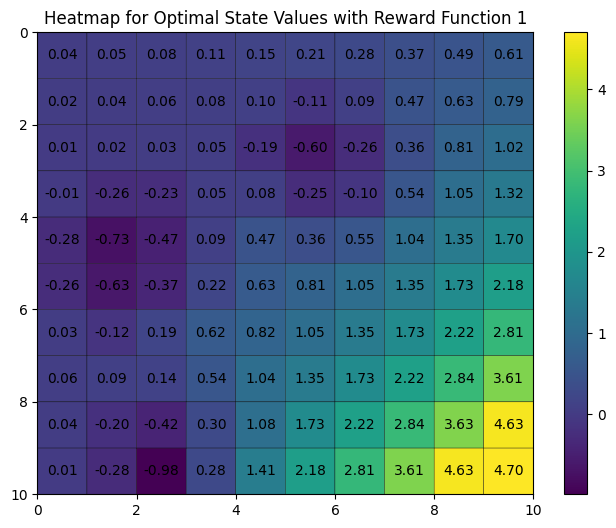

In [ ]:
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_opt.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values with Reward Function 1")
for (j, i), label in np.ndenumerate(V_opt.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 3:</b> The generated heat map is shown above.
</div>

<div class="alert alert-block alert-success">
<b>Question 4:</b> (15 points) Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in question 3 to explain)
</div>

<div class="alert alert-block alert-success">
<b>Answer 4:</b> Overall, from the distribution of the color in the heatmap, we can observe that the state 99 has the highest optimal value and the further the other states from state 99 are, the lower the optimal value they have. This is expected as state 99 is the only state that gives the reward based on the reward function 1. Moreover, besides this pattern, we can also see that those states that give negative reward have also relative low optimal value compared with their surrounding neighbors which give 0 reward. The closer the states are to these penalty states, the lower the optimal value relatively are. This also makes sense since the closer one state is to the negative reward, the higher it's probability is to get the negative reward. Combining these two aforementioned patterns, one can conclude that the patterns seen in the heatmap of the optimal values are roughly similar in the heatmap of reward function 1, but with more evenly dispersed values.
</div>

<div class="alert alert-block alert-success">
<b>Question 5:</b> Question 5: (20 points) Implement the computation step of the value iteration algorithm (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The optimal actions should be displayed using arrows. Does the optimal policy of the agent match your intuition? Please provide a brief explanation. Is it possible for the agent
to compute the optimal action to take at each state by observing the optimal values of it's neighboring states? In this question, you should have 1 plot.
</div>

In [7]:
"""
Implement the Computation (lines 14-17) steps of the Value Iteration algorithm
"""

# create an optimal state-value function
def optimal_policy_function(tp, rwd, state_space, actions, gamma, epsilon):
  # init
  Vs = np.zeros(len(state_space))
  delta = np.inf
  num_steps = 0
  old_Vs = np.copy(Vs)
  policy = np.zeros(100)

  while delta > epsilon:
    delta = 0
    for i in range(len(state_space)):
      Vs[i] = max([np.sum(tp[act][i]*(rwd + gamma*old_Vs)) for act in actions])
      delta = max(delta, abs(old_Vs[i] - Vs[i]))
    old_Vs = np.copy(Vs)
    num_steps += 1

  for i in range(len(state_space)):
    policy[i] = np.argmax([np.sum(tp[act][i]*(rwd + gamma*Vs)) for act in actions])
    
  return Vs, num_steps, policy


# plot arrow function
def plot_arrow(action_matrix):
    
    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'→'
            elif(c == 1):
                arrow = u'←'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'↓' 
            
            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()

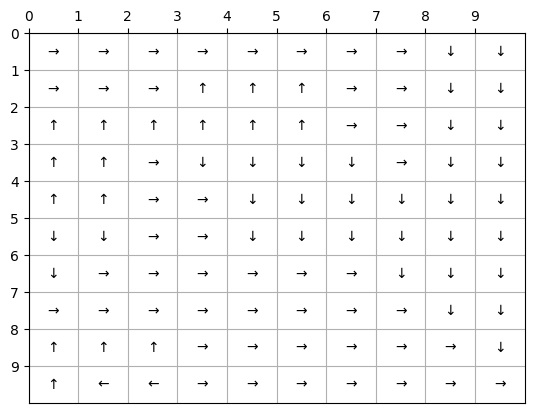

In [ ]:
V_opt, num_steps, P_opt = optimal_policy_function(tp, rwd, state_space, act_sets, gamma, epsilon)
plot_arrow(P_opt.reshape((10, 10)).T)

<div class="alert alert-block alert-success">
<b>Answer 5:</b> The result is plotted above and yes, the optimal policy of the agent match my intuition. According to the reward function 1 and optimal states values from previous part, we get the intuition that the overall action flow should point toward bottom-right corner and avoid the negative reward regions, which maximize each optimal state value. This intuition, indeed, can be observed in the plot shown above. If we connect the arrows of each state, one can see a flow of optimal policy leading toward state 99 and for those regions with negative reward, the flow goes around them to avoid penalty. Moreover, by combining this plot of optimal policy and the heatmap generated in Q3, one can see that it is possible for the agent to compute the optimal action to take at each state by observing the optimal values of it's neighboring states. In general, the optimal policy of a state points to the direction of the largest optimal values of its neighboring states. 
</div>

<div class="alert alert-block alert-success">
<b>Question 6:</b> (10 points) Modify the environment of the agent by replacing Reward function 1 with Reward function 2. Use the optimal state-value function implemented in question 2 to compute the optimal value of each state in the grid. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state. In this question, you should have 1 plot.
</div>

In [ ]:
# create a state_space for mapping of states numbering and coordinate
num_states = 100
state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)

# action set
num_acts = 4
act_sets = np.array(["right", "left", "up", "down"])

# reward function (#2) in 1D
rwd = rwd_f2.flatten("F")

# discount factor
gamma = 0.8

# transition probabilities matrix with probability w 
w = 0.1
tp = get_tp(w, act_sets, state_space)

Number of steps needed to converge: 32



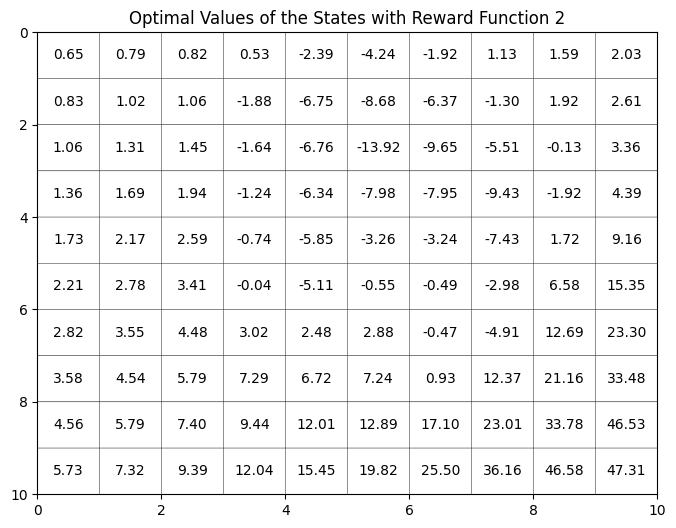

In [ ]:
epsilon = 0.01
V_opt, num_steps = optimal_state_value_function(tp, rwd, state_space, act_sets, gamma, epsilon)

# report
print("Number of steps needed to converge: {}\n".format(num_steps))
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_opt.reshape((10, 10)).T, edgecolors='black', cmap=ListedColormap(['white']))
plt.title("Optimal Values of the States with Reward Function 2")
for (j, i), label in np.ndenumerate(V_opt.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
# plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 6:</b> The plot is shown above.
</div>

<div class="alert alert-block alert-success">
<b>Question 7:</b> (20 points) Generate a heat map of the optimal state values (found in question 6) across the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier. Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in this question to explain)
</div>

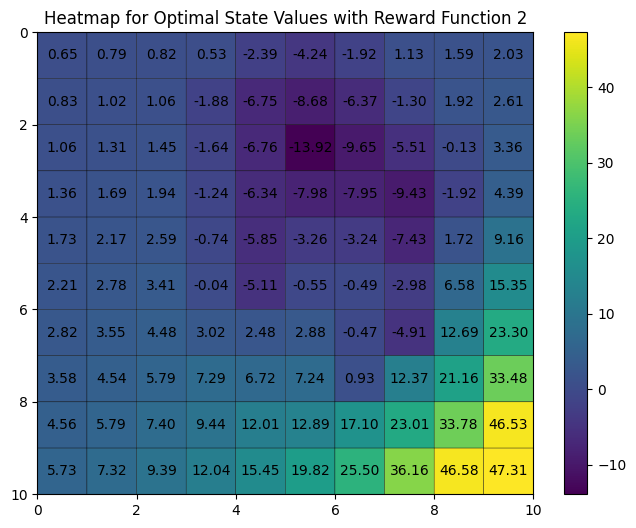

In [ ]:
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_opt.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values with Reward Function 2")
for (j, i), label in np.ndenumerate(V_opt.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 7:</b> The generated heatmap is plotted above. Similar idea to Q4, we can observe that the distribution of the optimal state values seen in this heatmap roughly resembles the patterns in the heatmap of reward function 2, but with more evenly dispersed values. This is expected since the closer a state is to the positive or negative reward state, the higher or lower its optimal state value will be due to the influence of the positive or negative reward.
</div>

<div class="alert alert-block alert-success">
<b>Question 8:</b> (20 points) Implement the computation step of the value iteration algorithm (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The optimal actions should be displayed using arrows. Does the optimal policy of the agent match your intuition? Please provide a brief explanation. In this question, you should have 1 plot.
</div>

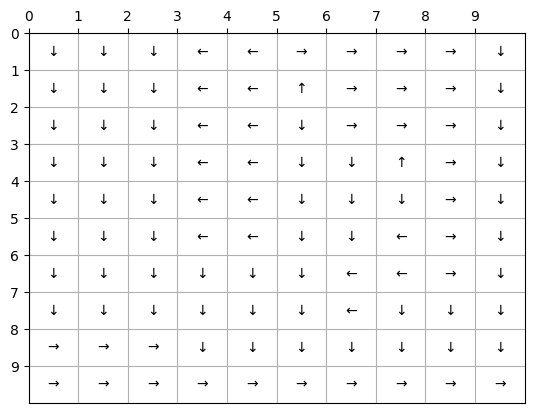

In [ ]:
V_opt, num_steps, P_opt = optimal_policy_function(tp, rwd, state_space, act_sets, gamma, epsilon)
plot_arrow(P_opt.reshape((10, 10)).T)

<div class="alert alert-block alert-success">
<b>Answer 8:</b> The result is plotted above and yes, the optimal policy of the agent match my intuition. Similar to Q5, we can get the intuition from the reward function 2 and the optimal states values that the overall flow of the optimal policy should lead toward bottom-right corner and avoid as well as go around the negative reward regions in order to reach the maximal optimal state values. This, indeed, can be observed in the plot shown above.
</div>

<div class="alert alert-block alert-success">
<b>Question 9:</b> (20 points) Change the hyper parameter $w$ to 0.6 and find the optimal policy map similar to previous question for reward functions. Explain the differences you observe. What do you think about value of new w compared to previous value? Choose the w that you think give rise to better optimal policy and use that w for the next stages of the project.
</div>

Number of steps needed to converge: 19



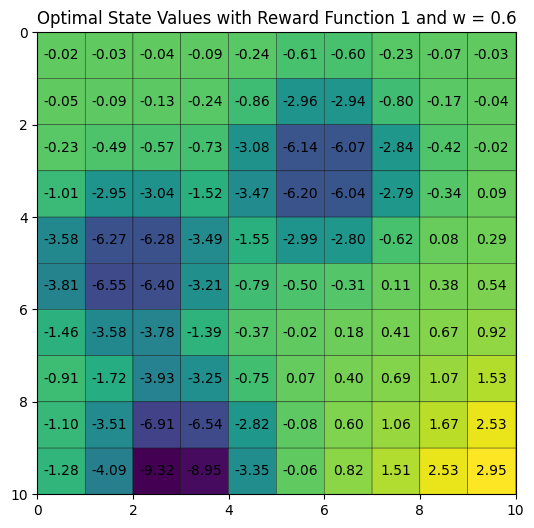

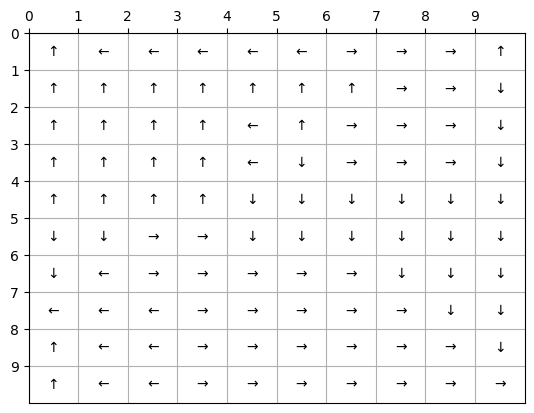

In [ ]:
# setting
rwd = rwd_f1.flatten("F")
w = 0.6
tp = get_tp(w, act_sets, state_space)

# plot optimal state value 
V_opt, num_steps = optimal_state_value_function(tp, rwd, state_space, act_sets, gamma, epsilon)
print("Number of steps needed to converge: {}\n".format(num_steps))
plt.figure(figsize=(6.17, 6))
plt.pcolor(V_opt.reshape((10, 10)).T, edgecolors='black')
plt.title("Optimal State Values with Reward Function 1 and w = 0.6")
for (j, i), label in np.ndenumerate(V_opt.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
# plt.colorbar()
plt.show()

# plot optimal policy
V_opt, num_steps, P_opt = optimal_policy_function(tp, rwd, state_space, act_sets, gamma, epsilon)
plot_arrow(P_opt.reshape((10, 10)).T)

Number of steps needed to converge: 27



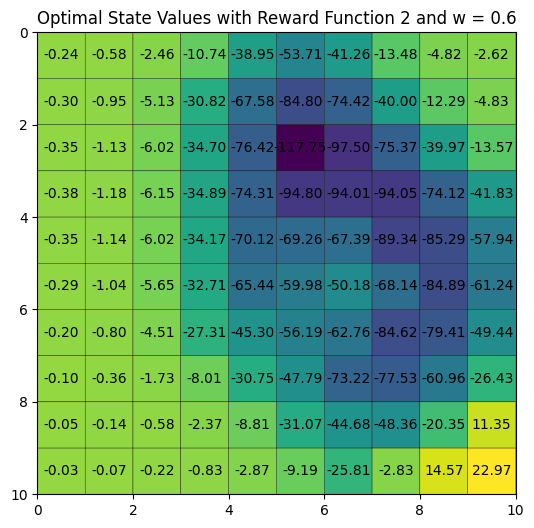

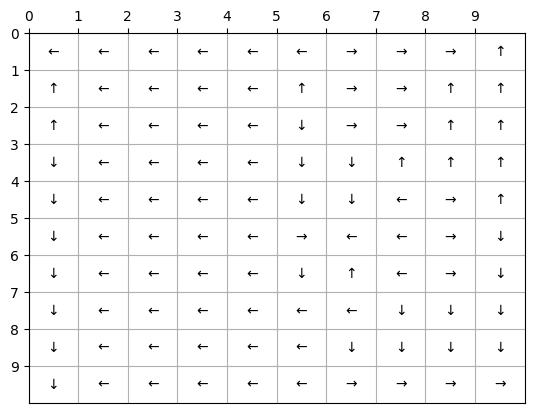

In [ ]:
# setting
rwd = rwd_f2.flatten("F")
w = 0.6
tp = get_tp(w, act_sets, state_space)

# plot optimal state value 
V_opt, num_steps = optimal_state_value_function(tp, rwd, state_space, act_sets, gamma, epsilon)
print("Number of steps needed to converge: {}\n".format(num_steps))
plt.figure(figsize=(6.17, 6))
plt.pcolor(V_opt.reshape((10, 10)).T, edgecolors='black')
plt.title("Optimal State Values with Reward Function 2 and w = 0.6")
for (j, i), label in np.ndenumerate(V_opt.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
# plt.colorbar()
plt.show()

# plot optimal policy
V_opt, num_steps, P_opt = optimal_policy_function(tp, rwd, state_space, act_sets, gamma, epsilon)
plot_arrow(P_opt.reshape((10, 10)).T)

<div class="alert alert-block alert-success">
<b>Answer 9:</b> The results based on $w = 0.6$ with reward function 1 and 2 are shown above. We can observe that the overall optimal state values with both reward functions are lower than the one based on $w = 0.1$. This is especially obvious in state 99 as well as its surrounding neighbors. For $w = 0.1$, state 99 and its neighbors have an optimal state value over 4.6 and 46 for each reward function, respectively. However, for $w = 0.6$, their optimal state value reduces to less than 3 and 25. Moreover, the regions of the negative optimal state value are expended, which can be observed from the color distribution of the heatmap. This is expected as the higher the probability $w$ is, the larger the influence of moving in a random direction due to wind exists, which leads to a lower reward expectation value particularly for the states that are closer to the negative reward states. From the policy plots, we can see that the arrows are mostly pointing out of the grid instead of creating a flow toward the positive reward. The reason for this is the increase of the influence and overpower of the negative reward states due to increase of probability $w$. Therefore, we can see that the further states from state 99 like states [0, 1, 2, 10, 11, 12, 20, 21, 22] are moving out of the grid instead of trying to reach the state 99 to avoid any possibility of getting penalty. In summary, based on all the aforementioned observations and explanations, we can conclude that the appropriate value of probability $w$ is 0.1 as the agent is more likely to try to reach the positive reward state while not afraid of encountering the negative reward and can perform some exploration in the grid.
</div>

# 4. Inverse Reinforcement learning (IRL)

## 4.1 IRL algorithm

<div class="alert alert-block alert-success">
<b>Question 10:</b> (10 points) Express $c$, $x$, $D$, $b$ in terms of $R$, $P_{a}$, $P_{a_{1}}$, $t_{i}$, $u$, $\lambda$ and $R_{max}$
</div>

<div class="alert alert-block alert-success">
<b>Answer 10:</b> For $|A| = 4$ and $|s| = 100$

$$
c = \begin{bmatrix} \mathbf{1}_{|s| \times 1} \\ - \lambda \mathbf{1}_{|s| \times 1} \\ \mathbf{0}_{|s| \times 1} \end{bmatrix}
x = \begin{bmatrix} t_{|s| \times 1} \\ u_{|s| \times 1}  \\ R_{|s| \times 1}\end{bmatrix}
b = \begin{bmatrix} \mathbf{0}_{(|A|-1) \cdotp |s| \times 1} \\ \mathbf{0}_{(|A|-1) \cdotp |s| \times 1} \\ \mathbf{0}_{|s| \times 1} \\ \mathbf{0}_{|s| \times 1} \\ R_{max} \mathbf{1}_{|s| \times 1} \\ R_{max} \mathbf{1}_{|s| \times 1}\end{bmatrix}
$$

$$
D = \begin{bmatrix} \mathbf{I}_{(|A|-1) \cdotp |s| \times |s|} & \mathbf{0}_{(|A|-1) \cdotp |s| \times |s|} & [(P_{a_{2 \cdots |A|}} - P_{a_{1}})(I-\gamma P_{a_{1}})^{-1}]_{(|A|-1) \cdotp |s| \times |s|} \\ \mathbf{0}_{(|A|-1) \cdotp |s| \times |s|} & \mathbf{0}_{(|A|-1) \cdotp |s| \times |s|} & [(P_{a_{2 \cdots |A|}} - P_{a_{1}})(I-\gamma P_{a_{1}})^{-1}]_{(|A|-1) \cdotp |s| \times |s|} \\ \mathbf{0}_{|s| \times |s|} & - \mathbf{I}_{|s| \times |s|} & \mathbf{I}_{|s| \times |s|} \\ \mathbf{0}_{|s| \times |s|} & - \mathbf{I}_{|s| \times |s|} & - \mathbf{I}_{|s| \times |s|} \\ \mathbf{0}_{|s| \times |s|} & \mathbf{0}_{|s| \times |s|} & \mathbf{I}_{|s| \times |s|} \\ \mathbf{0}_{|s| \times |s|} & \mathbf{0}_{|s| \times |s|} & - \mathbf{I}_{|s| \times |s|} \end{bmatrix} 
$$

</div>

<div class="alert alert-block alert-success">
<b>Question 11:</b> (30 points) Sweep $\lambda$ from 0 to 5 to get 500 evenly spaced values for $\lambda$. For each value of $\lambda$ compute $O_{A}(s)$ by following the process described above. For this problem, use the optimal policy of the agent found in question 5 to fill in the $O_{E}(s)$ values. Then use equation 3 to compute the accuracy of the IRL algorithm for this value of $\lambda$. You need to repeat the above process for all 500 values of $\lambda$ to get 500 data points. Plot $\lambda$ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.
</div>

In [10]:
def irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_):
  # parameter
  num_states = len(state_space)
  num_acts = len(act_sets)

  # init 
  I = np.identity(num_states)
  Z = np.zeros((num_states, num_states))
  P_a1 = np.zeros((num_states, num_states))
  P_as = np.zeros((3, num_states, num_states))
  D = np.array([])

  # get P_a1 and P_as
  for i in range(len(P_exp)):
    policy_direction = act_sets[int(P_exp[i])]
    P_a1[i, :] = tp[policy_direction][i]
    other_actions = np.setdiff1d(range(num_acts), P_exp[i])
    for j, a in enumerate(other_actions):
      P_as[j, i, :] = tp[act_sets[a]][i]

  # get c, D, b matrices
  for i in range(num_acts-1):
    P_a = P_as[i]
    temp = np.hstack((I, Z, np.matmul(P_a - P_a1, np.linalg.inv(I - gamma*P_a1))))
    temp = np.vstack((temp, 
                      np.hstack((Z, Z, np.matmul(P_a - P_a1, np.linalg.inv(I - gamma*P_a1))))))
    if D.shape[0] == 0:
      D = temp
    else:
      D = np.vstack((temp, D))

  D = np.vstack((D,
                 np.hstack((Z, -I, I)), 
                 np.hstack((Z, -I, -I)),
                 np.hstack((Z, Z, I)),
                 np.hstack((Z, Z, -I))))
  
  b = np.vstack((np.zeros(((num_acts-1)*num_states, 1)), 
                 np.zeros(((num_acts-1)*num_states, 1)), 
                 np.zeros((num_states, 1)), 
                 np.zeros((num_states, 1)), 
                 R_max*np.ones((num_states, 1)),
                 R_max*np.ones((num_states, 1))))

  c = np.vstack((np.ones((num_states, 1)),
                 -lambda_*np.ones((num_states, 1)), 
                 np.zeros((num_states, 1))))
  
  # solve x and get predicted R
  solvers.options['show_progress']=False
  sol = solvers.lp(-matrix(c), matrix(D), matrix(b))
  R = np.array(sol['x'][-100:]).squeeze()

  return R


def accuracy(exp_pol,ag_pol):
  num_states = len(exp_pol)
  count = 0.0
  for i in range(num_states):
    if exp_pol[i] == ag_pol[i]:
      count += 1
    
  return np.divide(count, num_states)

In [11]:
# env setup with reward function 1 and w = 0.1
num_states = 100
state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)
num_acts = 4
act_sets = np.array(["right", "left", "up", "down"])
rwd = rwd_f1.flatten("F")
R_max = rwd.max()
gamma = 0.8
epsilon = 0.01
w = 0.1
tp = get_tp(w, act_sets, state_space)

# get GT optimal policy from expert [P_opt] based on reward function 1
V_exp, num_steps_exp, P_exp = optimal_policy_function(tp, rwd, state_space, 
                                                      act_sets, gamma, epsilon)

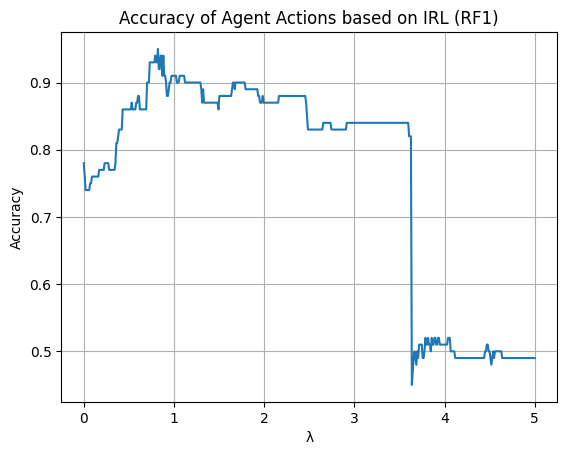

In [12]:
'''
Sweep λ from 0 to 5, and compute the IRL accuracy
'''
lambdas = np.linspace(0, 5, 500)
accs = []
for lambda_ in lambdas:
  extracted_rwd = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_)
  V_agent, num_steps_agent, P_agent = optimal_policy_function(tp, extracted_rwd, state_space, 
                                                              act_sets, gamma, epsilon)
  accs.append(accuracy(P_exp, P_agent))

# plot
plt.plot(lambdas, accs)
plt.xlabel("λ")
plt.ylabel("Accuracy")
plt.title("Accuracy of Agent Actions based on IRL (RF1)")
plt.grid()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 11:</b> The result is shown above.
</div>

<div class="alert alert-block alert-success">
<b>Question 12:</b> (5 points) Use the plot in question 11 to compute the value of $\lambda$ for which accuracy is maximum. For future reference we will denote this value as $\lambda_{max}^{(1)}$. Please report $\lambda_{max}^{(1)}$
</div>

In [13]:
acc_max_1 = np.max(accs)
lambda_max_1 = lambdas[np.argmax(accs)]
print("For Lambda equal to {}, "\
      "we reach the maximum accuracy {:.2f}%".format(lambda_max_1, acc_max_1*100))

For Lambda equal to 0.8216432865731462, we reach the maximum accuracy 95.00%


<div class="alert alert-block alert-success">
<b>Answer 12:</b> $\lambda_{max}^{(1)}$ is 0.8216432865731462 with accuracy equal to 95%
</div>

<div class="alert alert-block alert-success">
<b>Question 13:</b> (15 points) For $\lambda_{max}^{(1)}$, generate heat maps of the ground truth reward and the extracted reward. Please note that the ground truth reward is the Reward function 1 and the extracted reward is computed by solving the linear program given by equation 2 with the $\lambda$ parameter set to $\lambda_{max}^{(1)}$. In this question, you should have 2 plots.
</div>

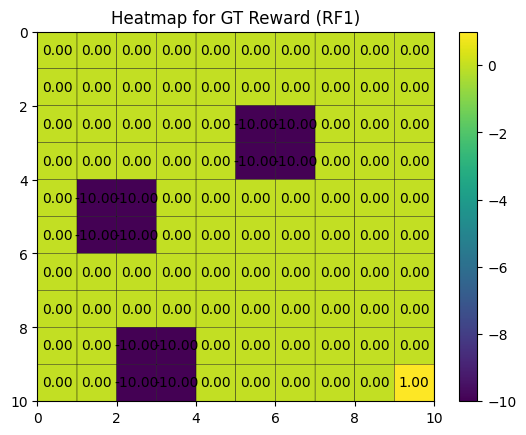

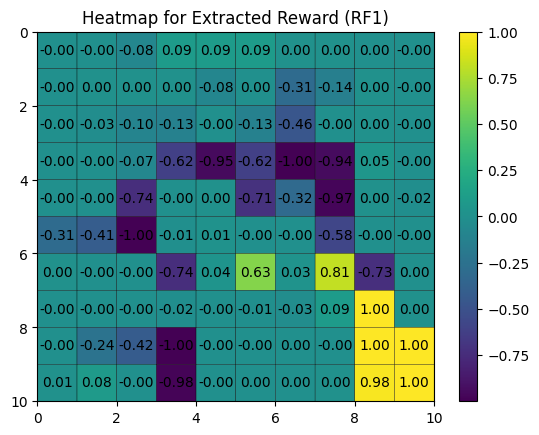

In [15]:
extracted_rwd_1 = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_max_1)

plt.pcolor(rwd_f1, edgecolors='black')
plt.title("Heatmap for GT Reward (RF1)")
for (j,i),label in np.ndenumerate(rwd_f1):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.pcolor(extracted_rwd_1.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Extracted Reward (RF1)")
for (j,i),label in np.ndenumerate(extracted_rwd_1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 13:</b> The results are shown above.
</div>

<div class="alert alert-block alert-success">
<b>Question 14:</b> (10 points) Use the extracted reward function computed in question 13, to compute the optimal values of the states in the 2-D grid. For computing the optimal values you need to use the optimal state-value function that you wrote in question 2. For visualization purpose, generate a heat map of the optimal state values across the 2-D grid (similar to the figure generated in question 3). In this question, you should have 1 plot.
</div>

Number of steps needed to converge: 22



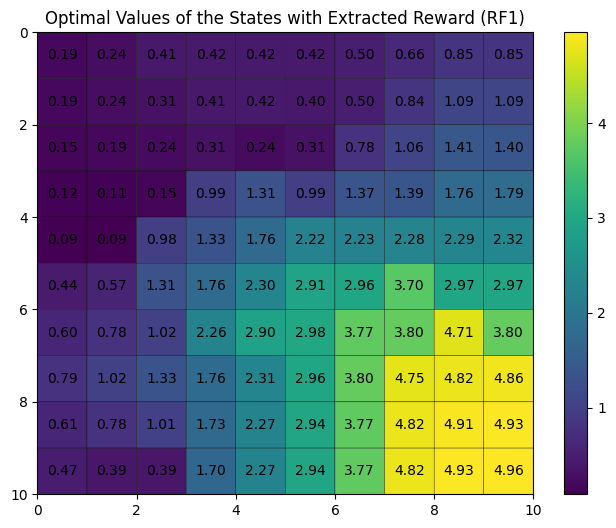

In [16]:
V_agent_1, num_steps_1 = optimal_state_value_function(tp, extracted_rwd_1, state_space, 
                                                      act_sets, gamma, epsilon)

# report
print("Number of steps needed to converge: {}\n".format(num_steps_1))
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_1.reshape((10, 10)).T, edgecolors='black')
plt.title("Optimal Values of the States with Extracted Reward (RF1)")
for (j, i), label in np.ndenumerate(V_agent_1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 14:</b> The heat map of the optimal state values is shown above.
</div>

<div class="alert alert-block alert-success">
<b>Question 15:</b> (10 points) Compare the heat maps of Question 3 and Question 14 and provide a brief explanation on their similarities and differences.
</div>

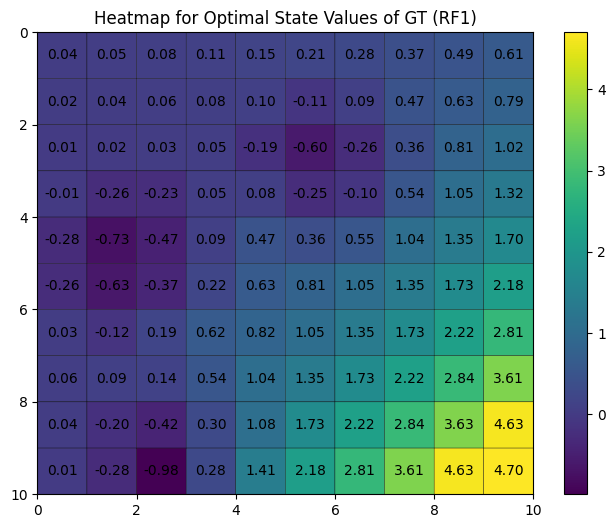

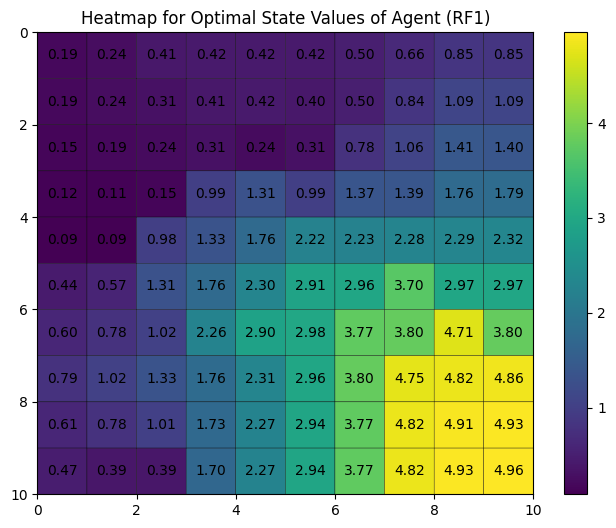

In [17]:
V_agent_1, num_steps_1 = optimal_state_value_function(tp, extracted_rwd_1, state_space, 
                                                      act_sets, gamma, epsilon)

# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_exp.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values of GT (RF1)")
for (j, i), label in np.ndenumerate(V_exp.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_1.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values of Agent (RF1)")
for (j, i), label in np.ndenumerate(V_agent_1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 15:</b> Overall, both heatmap generally have similar color distribution from top-left corner to bottom-right corner, corresponding to low state values to high state values, where state 99 yields the highest state value around 5.0. This is expected as we already knew from the privious part that this extracted reward function leads to a 95% accuracy of optimal policy, which proves the success of its functionality. However, one can also notice some differences such as the regions with negative values in the ground truth heatmap are disappaered in the heatmap of the agent. Moreover, the range of the optimal state values as well as the value decreasing rate between each neighboring states in the heatmap of the agent becomes smaller, meaning that the as an agent moves towards states with low reward, the optimal values of the neighboring states won't drop that progressively. Similarly, if an agent moves towards desirable states with higher reward, the optimal state values of the states it faces will also only slowly increase. This can also be explained based on the plotted extracted reward function heatmap shown in Q13. One can see that for this extracted reward function, there isn't any huge negative reward such as -10, instead the lowest is only -1. Furthermore, it is obvious to see that there are more positive and negative reward states, spreading across other states compared to the ground truth reward function 1. Therefore, it is expected that the derived optimal state values will also be more equally distributed as we can tell in the plot here.
</div>

<div class="alert alert-block alert-success">
<b>Question 16:</b> (10 points) Use the extracted reward function found in question 13 to compute the optimal policy of the agent. For computing the optimal policy of the agent you need to use the function that you wrote in question 5. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The actions should be displayed using arrows. In this question, you should have 1 plot.
</div>

In [72]:
# plot arrow function
def plot_arrow_diff(P_agent, P_exp, state_space, title):
    
    diff_idx = np.where(P_agent != P_exp)[0]
    diff_coor = [state_space[i] for i in diff_idx]
    action_matrix = P_agent.reshape((10, 10)).T

    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'→'
            elif(c == 1):
                arrow = u'←'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'↓' 
            
            if (i, j) in diff_coor:
              ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center', color='red')
            else:
              ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.set_title(title)
    ax.xaxis.tick_top()
    ax.grid()

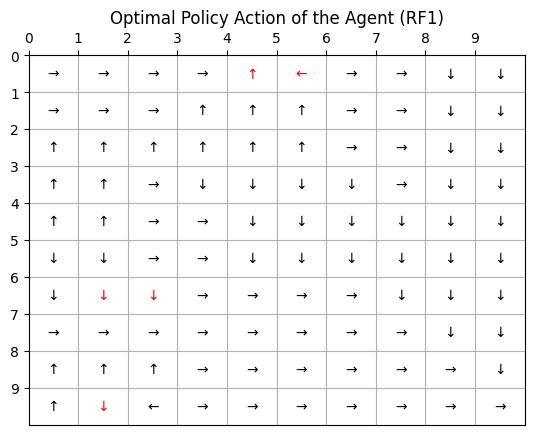

In [55]:
# get optimal policy based on extracted reward
V_agent_1, num_steps_agent_1, P_agent_1 = optimal_policy_function(tp, extracted_rwd_1,
                                                                  state_space, act_sets, 
                                                                  gamma, epsilon)

# get optimal policy based on GT reward
V_exp_1, num_steps_exp_1, P_exp_1 = optimal_policy_function(tp, rwd_f1.flatten("F"),
                                                            state_space, act_sets,
                                                            gamma, epsilon)

# make plot
title = "Optimal Policy Action of the Agent (RF1)"
plot_arrow_diff(P_agent_1, P_exp_1, state_space, title)

<div class="alert alert-block alert-success">
<b>Answer 16:</b> The result is shown above. Arrows with different direction compared to the ground truth are marked in red.
</div>

<div class="alert alert-block alert-success">
<b>Question 17:</b> (10 points) Compare the figures of Question 5 and Question 16 and provide a brief explanation on their similarities and differences.
</div>

<div class="alert alert-block alert-success">
<b>Answer 17:</b> Based on the plot in Q16, we can see that overall most of the arrows are pointed toward the right direction as the ground truth policy of the expert. However, there are in total 5 arrows pointing to different direction, which kind of break the original flow of the expert policy. This can be explained through the optimal state values of the agent. As we know from discussion and observation in the answer of Q5, it is possible for the agent
to compute the optimal action to take at each state by observing the optimal values of it's neighboring. Therefore, by oberving the optimal state values of the agent with the extracted reward funciton, one can understand why some arrows in those 5 certain states will point to the wrong direction.
</div>

<div class="alert alert-block alert-success">
<b>Question 18:</b> (30 points) Sweep $\lambda$ from 0 to 5 to get 500 evenly spaced values for $\lambda$. For each value of $\lambda$ compute $O_{A}(s)$ by following the process described above. For this problem, use the optimal policy of the agent found in question 8 to fill in the $O_{E}(s)$ values. Then use equation 3 to compute the accuracy of the IRL algorithm for this value of $\lambda$. You need to repeat the above process for all 500 values of $\lambda$ to get 500 data points. Plot $\lambda$ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.
</div>

In [56]:
# env setup with reward function 2 and w = 0.1
num_states = 100
state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)
num_acts = 4
act_sets = np.array(["right", "left", "up", "down"])
rwd = rwd_f2.flatten("F")
R_max = rwd.max()
gamma = 0.8
epsilon = 0.01
w = 0.1
tp = get_tp(w, act_sets, state_space)

# get GT optimal policy from expert [P_opt] based on reward function 2
V_exp, num_steps_exp, P_exp = optimal_policy_function(tp, rwd, state_space, 
                                                      act_sets, gamma, epsilon)

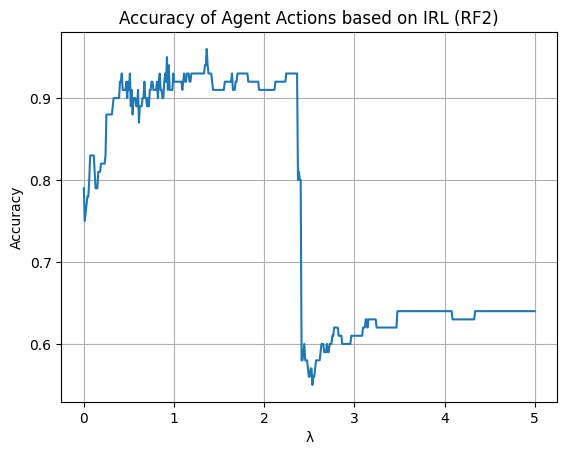

In [58]:
'''
Sweep λ from 0 to 5, and compute the IRL accuracy
'''
lambdas = np.linspace(0, 5, 500)
accs = []
for lambda_ in lambdas:
  extracted_rwd = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_)
  V_agent, num_steps_agent, P_agent = optimal_policy_function(tp, extracted_rwd, state_space, 
                                                              act_sets, gamma, epsilon)
  accs.append(accuracy(P_exp, P_agent))

# plot
plt.plot(lambdas, accs)
plt.xlabel("λ")
plt.ylabel("Accuracy")
plt.title("Accuracy of Agent Actions based on IRL (RF2)")
plt.grid()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 18:</b> The result is plotted above.
</div>

<div class="alert alert-block alert-success">
<b>Question 19:</b> (5 points) Use the plot in question 18 to compute the value of $\lambda$ for which accuracy is maximum. For future reference we will denote this value as $\lambda_{max}^{(2)}$. Please report $\lambda_{max}^{(2)}$
</div>

In [59]:
acc_max_2 = np.max(accs)
lambda_max_2 = lambdas[np.argmax(accs)]
print("For Lambda equal to {}, "\
      "we reach the maximum accuracy {:.2f}%".format(lambda_max_2, acc_max_2*100))

For Lambda equal to 1.3627254509018036, we reach the maximum accuracy 96.00%


<div class="alert alert-block alert-success">
<b>Answer 19:</b> $\lambda_{max}^{(2)}$ is 1.3627254509018036 with accuracy equal to 96%
</div>

<div class="alert alert-block alert-success">
<b>Question 20:</b> (15 points) For $\lambda_{max}^{(2)}$, generate heat maps of the ground truth reward and the extracted reward. Please note that the ground truth reward is the Reward function 2 and the extracted reward is
computed by solving the linear program given by equation 2 with the $\lambda$ parameter set to $\lambda_{max}^{(2)}$. In this question, you should have 2 plots.
</div>

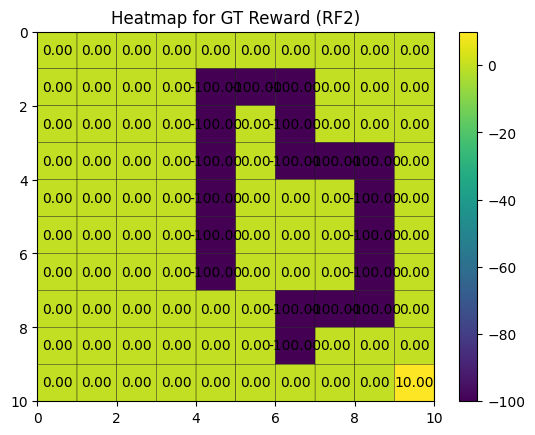

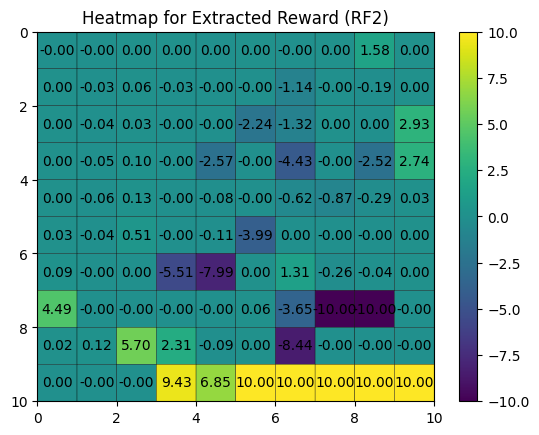

In [69]:
extracted_rwd_2 = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_max_2)

plt.pcolor(rwd_f2, edgecolors='black')
plt.title("Heatmap for GT Reward (RF2)")
for (j,i),label in np.ndenumerate(rwd_f2):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.pcolor(extracted_rwd_2.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Extracted Reward (RF2)")
for (j,i),label in np.ndenumerate(extracted_rwd_2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 20:</b> The plots are shown above.
</div>

<div class="alert alert-block alert-success">
<b>Question 21:</b> (10 points) Use the extracted reward function computed in question 20, to compute the optimal values of the states in the 2-D grid. For computing the optimal values you need to use the optimal state-value function that you wrote in question 2. For visualization purpose, generate a heat
map of the optimal state values across the 2-D grid (similar to the figure generated in question 7). In this question, you should have 1 plot.
</div>

Number of steps needed to converge: 32



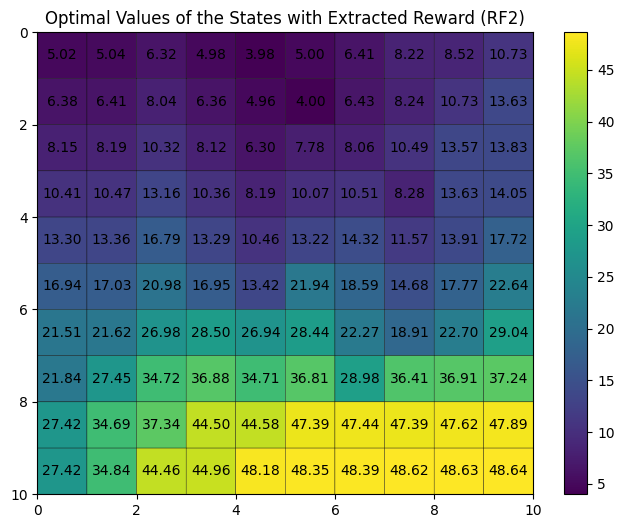

In [61]:
V_agent_2, num_steps_2 = optimal_state_value_function(tp, extracted_rwd_2, state_space, 
                                                      act_sets, gamma, epsilon)

# report
print("Number of steps needed to converge: {}\n".format(num_steps_2))
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_2.reshape((10, 10)).T, edgecolors='black')
plt.title("Optimal Values of the States with Extracted Reward (RF2)")
for (j, i), label in np.ndenumerate(V_agent_2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 21:</b> The result is shown above.
</div>

<div class="alert alert-block alert-success">
<b>Question 22:</b> (10 points) Compare the heat maps of Question 7 and Question 21 and provide a brief explanation on their similarities and differences.
</div>

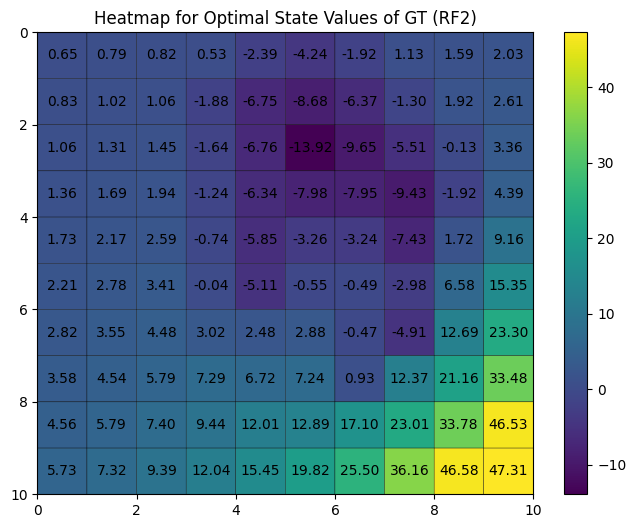

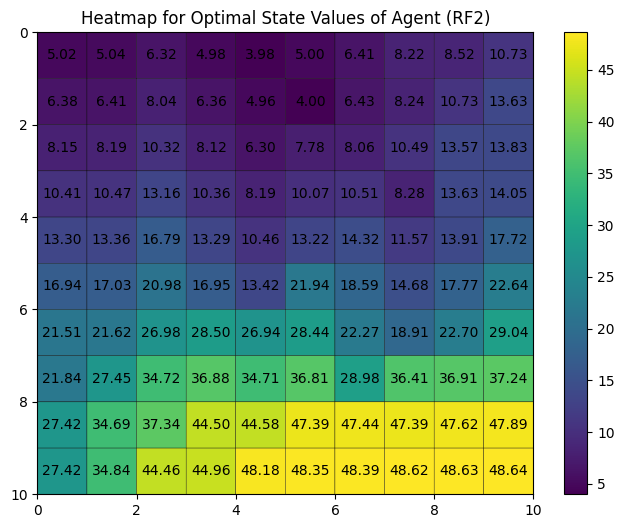

In [70]:
V_agent_2, num_steps_2 = optimal_state_value_function(tp, extracted_rwd_2, state_space, 
                                                      act_sets, gamma, epsilon)

# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_exp.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values of GT (RF2)")
for (j, i), label in np.ndenumerate(V_exp.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_2.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values of Agent (RF2)")
for (j, i), label in np.ndenumerate(V_agent_2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<b>Answer 22:</b> This time, one can observe a relative large different distribution among the optimal state values of the expert and the agent. For similarities, the state 99 in both heatmap has the highest optimal state values and The farther away a state from state 99, the lower the optimal state value of a state gradually becomes. For differences, one can see that the negative optimal values are all gone in the second plot and there are actually more states that could achieve an optimal state value over 40.  
</div>

<div class="alert alert-block alert-success">
<b>Question 23:</b> (10 points) Use the extracted reward function found in question 20 to compute the optimal policy of the agent. For computing the optimal policy of the agent you need to use the function that you wrote in question 9. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The actions should be displayed using arrows. In this question, you should have 1 plot.
</div>

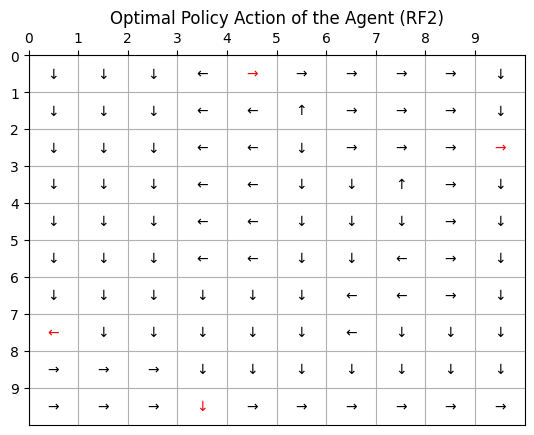

In [78]:
# get optimal policy based on extracted reward
V_agent_2, num_steps_agent_2, P_agent_2 = optimal_policy_function(tp, extracted_rwd_2,
                                                                  state_space, act_sets, 
                                                                  gamma, epsilon)

# get optimal policy based on GT reward
V_exp_2, num_steps_exp_2, P_exp_2 = optimal_policy_function(tp, rwd_f2.flatten("F"),
                                                            state_space, act_sets,
                                                            gamma, epsilon)

# make plot
title = "Optimal Policy Action of the Agent (RF2)"
plot_arrow_diff(P_agent_2, P_exp_2, state_space, title)

<div class="alert alert-block alert-success">
<b>Answer 23:</b> The result is shown above. Arrows with different direction compared to the ground truth are marked in red.
</div>

<div class="alert alert-block alert-success">
<b>Question 24:</b> Compare the figures of Question 9 and Question 23 and provide a brief explanation on their similarities and differences.
</div>

<div class="alert alert-block alert-success">
<b>Answer 24:</b> Here we yield the similar result as in Q16. Based on the plot in Q24, we can see that overall most of the arrows are pointed toward the right direction as the ground truth policy of the expert. However, there are in total 4 arrows pointing to different direction, which can be explained through the optimal state values of the agent as well. By oberving the optimal state values of the agent with the extracted reward funciton, one can understand why some arrows in those 4 certain states will point to the wrong direction. Moreover, in some states the neighboring optimal values are relative close, no huge difference. Thus, the policy is confused in those states.

</div>

<div class="alert alert-block alert-success">
<b>Question 25:</b> (50 points) From the figure in question 23, you should observe that the optimal policy of the agent has two major discrepancies. Please identify and provide the causes for these two discrepancies. One of the discrepancy can be fixed easily by a slight modification to the value iteration algorithm. Perform this modification and re-run the modified value iteration algorithm to compute the optimal policy of the agent. Also, recompute the maximum accuracy after this modification. Is there a change in maximum accuracy? The second discrepancy is harder to fix and is a limitation of the simple IRL algorithm.
</div>

In [87]:
# edit the value iteration algorithm
def value_iteration_Q25(tp, rwd, state_space, actions, gamma, epsilon):
  Vs = np.zeros(len(state_space))
  delta = np.inf
  num_steps = 0
  old_Vs = np.copy(Vs)
  policy = np.zeros(100)

  while delta > epsilon:
    delta = 0
    for i in range(len(state_space)):
      Vs[i] = max([np.sum(tp[act][i]*(rwd + gamma*old_Vs)) for act in actions])
      delta = max(delta, abs(old_Vs[i] - Vs[i]))
    old_Vs = np.copy(Vs)
    num_steps += 1

  for i in range(len(state_space)):
    temp = [np.sum(tp[act][i]*(rwd + gamma*Vs)) for act in actions]
    
    # convert the state value that goes off the grid to '-np.inf' to constrain going off the grid
    if i != 99:
      if i >= 90:
        temp[0] = -np.inf  # right edge
      if i <= 9:
        temp[1] = -np.inf  # left edge
      if i%10 == 0:
        temp[2] = -np.inf  # top edge
      if i%10 == 9:
        temp[3] = -np.inf  # bottom edge
    ###########################################################################################

    policy[i] = np.argmax(temp)
    
  return Vs, num_steps, policy

The new accuracy based on new value iteration algorithm: 98.00%



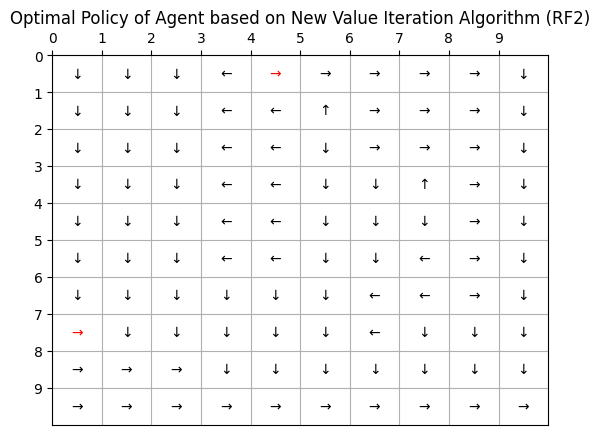

In [91]:
extracted_rwd_Q25 = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_max_2)

# get new optimal policy based on extracted rewar
V_agent_Q25, num_steps_agent_Q25, P_agent_Q25 = value_iteration_Q25(tp, extracted_rwd_2,
                                                                    state_space, act_sets,
                                                                    gamma, epsilon)

# # get optimal policy based on GT reward
# V_exp_2, num_steps_exp_2, P_exp_2 = optimal_policy_function(tp, rwd_f2.flatten("F"),
#                                                             state_space, act_sets,
#                                                             gamma, epsilon)
acc_Q25 = accuracy(P_exp_2, P_agent_Q25)
print("The new accuracy based on new value iteration algorithm: {:.2f}%\n".format(acc_Q25*100))

# make plot
title = "Optimal Policy of Agent based on New Value Iteration Algorithm (RF2)"
plot_arrow_diff(P_agent_Q25, P_exp_2, state_space, title)

<div class="alert alert-block alert-success">
<b>Answer 25:</b> The first discrepancy one can observe is that the policy of some states at the edges or corner is moving off the grid instead of following the flow pointed toward the positive reward direction. This is because the way we designed the transition probability as well as the value iteration function might potentially mislead those states to prefer to take the policy that will let them stay in the their current state because of a higher probability even though the optimal state value of that state itself is lower than it's neighboring nodes. The second discrepancy is the confusion of the correct policy, leading the agent to go toward the wrong or even opposite direction. This occurs because these states are influenced by local rewards that we extracted through IRL algorithm, which can accumulate rapidly in the incorrect direction and overshadow the potential maximum reward, making the agent to be confused about the correct direction. To fix the first discrepancy, I basically modify and set up a border constraint for all states at the edges or corner, besides state 99, in the value iteration algorithm by replacing the value to negative infinity so that the action, which causes the agent moving off the grid, is basically eliminated and could not be able to choose as the optimal policy at the end. With such modification, two incorrect arrows / policies have been fixed and the mamaximum accuracy increase from 96% to 98%.
</div>

In [ ]:
def irl(P_exp, tp, rwd, state_space, act_sets, gamma, lambda_):
  # parameter
  num_states = len(state_space)
  num_acts = len(act_sets)
  R_max = rwd.max()

  # init 
  I = np.identity(num_states)
  P_all = np.zeros(((num_acts-1)*num_states, num_states))
  iden_mat = np.zeros(((num_acts-1)*num_states, num_states))
  j = 0
  
  # get c, D, b matrices
  for i in range(len(P_exp)):
    policy_direction = act_sets[int(P_exp[i])]
    for action in act_sets:
      if (policy_direction == action):
        continue
      P_a1 = tp[policy_direction]
      P_a = tp[action]
      P_all[j, :] = np.matmul((P_a[i] - P_a1[i]).reshape(1, 100), 
                              np.linalg.inv(I - gamma*P_a1))
      iden_mat[j, i] = 1
      j += 1

  D = np.vstack((np.hstack((iden_mat, P_all, np.zeros(P_all.shape))), 
                 np.hstack((np.zeros(P_all.shape), P_all, np.zeros(P_all.shape))), 
                 np.hstack((np.zeros(I.shape), np.identity(num_states), -np.identity(num_states))),
                 np.hstack((np.zeros(I.shape), -np.identity(num_states), -np.identity(num_states))), 
                 np.hstack((np.zeros(I.shape), np.identity(num_states), np.zeros(I.shape))), 
                 np.hstack((np.zeros(I.shape), -np.identity(num_states), np.zeros(I.shape)))))

  b = np.vstack((np.zeros((P_all.shape[0], 1)), 
                 np.zeros((P_all.shape[0], 1)), 
                 np.zeros((num_states, 1)), 
                 np.zeros((num_states, 1)), 
                 R_max*np.ones((num_states, 1)),
                 R_max*np.ones((num_states, 1))))

  c = np.vstack((np.ones((num_states, 1)), 
                 np.zeros((num_states, 1)), 
                 -lambda_*np.ones((num_states, 1))))
  
  # solve x and get predicted R
  solvers.options['show_progress']=False
  sol = solvers.lp(-matrix(c), matrix(D), matrix(b))
  # R = np.array(sol['x'][100:200])
  R = np.array(sol['x'][-100:]).squeeze()

  return R